## Using GAN to generate new students data

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import os

# First of all we need to read all the csv files
# Folder containing the CSV files
folder_path = './dataframes/All_Subjects/Reduced/'

# Dictionary to store dataframes
dataframes = {}

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  # Check if the file is a CSV
        file_path = os.path.join(folder_path, filename)
        dataframes[filename] = pd.read_csv(file_path)  # Read the CSV and store it in the dictionary

# Reading the grades and concatenating with the other features

In [3]:
#read the grades file

df_grades = pd.read_fwf('./StudentGrades.txt', encoding='ANSI', header=None, names=['subject_grade'])

df_grades.head()

,subject_grade
0,GRADES - MIDTERM 1
1,------------------
2,S01 – 78
3,S02 – 82
4,S03 – 77


In [4]:
# Define the regex pattern of the data we want to keep
regex_pattern = r'S\d{2} – \d+'

# Filter rows based on the regex pattern
df_grades = df_grades[df_grades['subject_grade'].str.match(regex_pattern, na=False)]

#split data into two columns in pandas with regex on one side we have the subject and on the other side we have the grade
df_grades[['Subject', 'Grade']] = df_grades['subject_grade'].str.extract(r'(\d{2})\D+(\d+)')

#drop the subject_grade column
df_grades.drop(columns=['subject_grade'], inplace=True)

#convert the grade and subject columns to numeric
df_grades['Grade'] = pd.to_numeric(df_grades['Grade'])
df_grades['Subject'] = pd.to_numeric(df_grades['Subject'])

#reset the index
df_grades.reset_index(drop=True, inplace=True)

#create a new column with the exam type
#for the first 10 rows the exam type is 1, for the next 10 rows the exam type is 2 and so on
df_grades['Exam'] = df_grades.index // 10 + 1

In [ ]:
#iterate over the dataframes and merge them with the df_grades dataframe based on the subject

for key in dataframes:
    if 'Final' in key:
        df_final = df_grades[df_grades['Exam'] == 3]
        dataframes[key] = pd.merge(df_final, dataframes[key], left_on='Subject', right_on='subj').drop(columns=['subj'])
    elif 'midterm_1' in key:
        df_midterm_1 = df_grades[df_grades['Exam'] == 1]
        dataframes[key] = pd.merge(df_midterm_1, dataframes[key], left_on='Subject', right_on='subj').drop(columns=['subj'])
    elif 'midterm_2' in key:
        df_midterm_2 = df_grades[df_grades['Exam'] == 2]
        dataframes[key] = pd.merge(df_midterm_2, dataframes[key], left_on='Subject', right_on='subj').drop(columns=['subj'])
    
    dataframes[key].to_csv('./dataframes/All_Subjects/Reduced/' + key, index=False)

# One-shot metadata generation for model evaluation PAR - time series

In [12]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
df_features = dataframes['Processed_EDA_Final_Win_30.csv']

metadata.detect_from_dataframe(data=df_features)

metadata.update_column(column_name='Grade', sdtype='numerical')

#define the subject as identifier
metadata.update_column(column_name='Subject', sdtype='id')

#define the entities, i.e., the columns that identify the unique time-series in the data, the entities do not have a relatisionship between them
metadata.set_sequence_key(column_name='Subject')

#set the sequence index, i.e., the column that identifies the time in the time-series
metadata.set_sequence_index(column_name='t_sec')



Auto detected data:



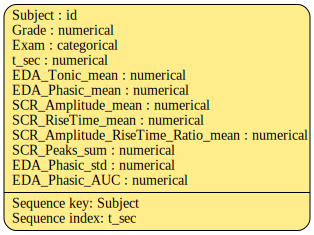

In [13]:
print('Auto detected data:\n')
metadata.visualize(show_table_details='full')

In [14]:
metadata.validate()

# PAR implementation w/ metadata creation

In [7]:
from sdv.sequential import PARSynthesizer

def generate_synthetic_data_par(metadata, df, key, n_samples=90):
    model = PARSynthesizer(
        metadata=metadata,
        context_columns=['Exam', 'Grade'],
        verbose=True,
        epochs=256,
        )

    model.fit(df)
    # store the model to disk in a pickle file
    model.save(f'./models/{key}.pkl')

    synthetic_data = model.sample(n_samples)

    synthetic_data.to_csv('./dataframes/All_Subjects/Synthetic_data/'+key+'.csv', index=False)

In [8]:
from sdv.metadata import SingleTableMetadata

def generate_and_validate_metadata_par(df):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df)
    metadata.update_column(column_name='Grade', sdtype='numerical')
    #define the subject as identifier
    metadata.update_column(column_name='Subject', sdtype='id')
    #define the entities, i.e., the columns that identify the unique time-series in the data, the entities do not have a relatisionship between them
    metadata.set_sequence_key(column_name='Subject')
    #set the sequence index, i.e., the column that identifies the time in the time-series
    metadata.set_sequence_index(column_name='t_sec')
    metadata.validate()
    return metadata

In [9]:
#iterate over the dataframes and generate synthetic data
for key in dataframes:
    metadata = generate_and_validate_metadata_par(dataframes[key])
    generate_synthetic_data_par(metadata, dataframes[key], key)

100%|██████████| 90/90 [01:07<00:00,  1.32it/s]


# Load the saved models and generate new data

In [3]:
from sdv.sequential import PARSynthesizer

loaded = PARSynthesizer.load('./models/Processed_EDA_Final_Win_30.csv.pkl')

synthetic_data = loaded.sample(num_sequences=10)

100%|██████████| 10/10 [00:42<00:00,  4.22s/it]


# Quality checking for generated data

In [41]:
from sdv.evaluation.single_table import evaluate_quality

#iterate over the dataframes and generate a report
for key in dataframes:
    df = dataframes[key]
    synthetic_data = pd.read_csv('./dataframes/All_Subjects/Synthetic_data/'+key+'.csv')
    metadata = generate_and_validate_metadata_par(df)
    print(f'\n Quality report for {key}:')
    quality_report = evaluate_quality(real_data=df,
                                      synthetic_data=synthetic_data,
                                      metadata=metadata,
                                      verbose=True
                                      )
    column_shapes = quality_report.get_visualization('Column Shapes')
    column_shapes.write_html(f'./reports/column_shapes_{key}.html')

    #change the size of the figure
    column_pairs = quality_report.get_visualization('Column Pair Trends')
    column_pairs.update_layout(width=2000, height=2000)
    column_pairs.write_html(f'./reports/column_pairs_{key}.html')

    quality_report.save(filepath=f'./reports/{key}.pkl')


 Quality report for Processed_EDA_Final_Win_120.csv:
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 66/66 [00:00<00:00, 108.42it/s]

Overall Quality Score: 78.25%

Properties:
- Column Shapes: 72.0%
- Column Pair Trends: 84.49%

 Quality report for Processed_EDA_Final_Win_30.csv:
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 66/66 [00:00<00:00, 73.57it/s] 

Overall Quality Score: 75.45%

Properties:
- Column Shapes: 65.46%
- Column Pair Trends: 85.44%

 Quality report for Processed_EDA_Final_Win_60.csv:
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 66/66 [00:00<00:00, 81.28it/s]

Overall Quality Score: 78.11%

Properties:
- Column Shapes: 70.06%
- Column Pair Trends: 86.16%

 Quality report for Processed_EDA_midterm_1_Win_120.csv:
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 66/66 [00:00<00:00, 152.59it/s]

Overall Quality Score: 86.03%

Properties:
- Column 

# Generate detailed stats for only the best model to put info in the paper

In [43]:
synthetic_data = pd.read_csv('./dataframes/All_Subjects/Synthetic_data/Processed_EDA_midterm_1_Win_120.csv.csv')

df_features = dataframes['Processed_EDA_midterm_1_Win_120.csv']

In [44]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=df_features,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 66/66 [00:00<00:00, 107.04it/s]

Overall Quality Score: 86.03%

Properties:
- Column Shapes: 82.29%
- Column Pair Trends: 89.77%


In [45]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,Grade,KSComplement,0.832099
1,Exam,TVComplement,1.000000
2,t_sec,KSComplement,1.000000
3,EDA_Tonic_mean,KSComplement,0.887407
4,EDA_Phasic_mean,KSComplement,0.915802
5,SCR_Amplitude_mean,KSComplement,0.643951
6,SCR_RiseTime_mean,KSComplement,0.623210
7,SCR_Amplitude_RiseTime_Ratio_mean,KSComplement,0.680494
8,SCR_Peaks_sum,KSComplement,0.705432
9,EDA_Phasic_std,KSComplement,0.843951


In [46]:
quality_report.get_details(property_name='Column Pair Trends')

,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation
0,Grade,Exam,ContingencySimilarity,0.730617,NaN,NaN
1,Grade,t_sec,CorrelationSimilarity,0.902419,7.973540e-19,-0.195162
2,Grade,EDA_Tonic_mean,CorrelationSimilarity,0.928891,2.424747e-02,0.166466
3,Grade,EDA_Phasic_mean,CorrelationSimilarity,0.985119,-3.971482e-02,-0.009953
4,Grade,SCR_Amplitude_mean,CorrelationSimilarity,0.961435,1.563661e-01,0.233496
5,Grade,SCR_RiseTime_mean,CorrelationSimilarity,0.920936,-9.559746e-02,0.062530
6,Grade,SCR_Amplitude_RiseTime_Ratio_mean,CorrelationSimilarity,0.958197,2.921859e-01,0.208580
7,Grade,SCR_Peaks_sum,CorrelationSimilarity,0.999919,2.438384e-01,0.243676
8,Grade,EDA_Phasic_std,CorrelationSimilarity,0.962026,6.607149e-02,0.142020
9,Grade,EDA_Phasic_AUC,CorrelationSimilarity,0.983126,-3.962488e-02,-0.005876


In [47]:
quality_report.get_visualization('Column Shapes')

In [55]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df_features,
    synthetic_data=synthetic_data,
    column_name='EDA_Phasic_AUC',
    metadata=metadata
)

fig.show()

In [54]:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=df_features,
    synthetic_data=synthetic_data,
    column_names=['EDA_Phasic_mean', 'Grade'],
    metadata=metadata
)

fig.show()

In [154]:
synthetic_data.to_csv("S1_averaged.csv")